In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem

from gptchem.evaluator import find_learning_curve_intersection, fit_learning_curve, lc
from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(["science", "nature"])

%matplotlib inline

## Load results

In [3]:
all_out = glob("out/**/*.pkl")

In [4]:
all_out = [load_pickle(p) for p in all_out]

In [5]:
extracted_res = []
xgboost_results = []
tabpfn_results = []

for out in all_out:
    try:
        res = {
            "train_size": out["train_size"],
            "frac_valid": out["frac_valid"],
            "accuracy": out["accuracy"],
            "f1_macro": out["f1_macro"],
            "f1_micro": out["f1_micro"],
            "kappa": out["kappa"],
            "num_classes": out["num_classes"],
            "representation": out["representation"],
        }
        extracted_res.append(res)
    except KeyError:
        pass

    xgb_res = {
        "train_size": out["train_size"],
        "accuracy": out["xgboost_baseline"]["accuracy"],
        "f1_macro": out["xgboost_baseline"]["f1_macro"],
        "f1_micro": out["xgboost_baseline"]["f1_micro"],
        "kappa": out["xgboost_baseline"]["kappa"],
        "num_classes": out["num_classes"],
    }

    tabpfn_res = {
        "train_size": out["train_size"],
        "accuracy": out["tabpfn_baseline"]["accuracy"],
        "f1_macro": out["tabpfn_baseline"]["f1_macro"],
        "f1_micro": out["tabpfn_baseline"]["f1_micro"],
        "kappa": out["tabpfn_baseline"]["kappa"],
        "num_classes": out["num_classes"],
    }

    xgboost_results.append(xgb_res)
    tabpfn_results.append(tabpfn_res)

In [6]:
res = pd.DataFrame(extracted_res)
xgboost_res = pd.DataFrame(xgboost_results)
tabpfn_res = pd.DataFrame(tabpfn_results)

In [7]:
grouped_res = res.groupby(["num_classes", "representation", "train_size"]).agg(["mean", "std", sem])

In [8]:
grouped_xgboost_res = xgboost_res.groupby(["num_classes", "train_size"]).agg(["mean", "std", sem])

In [9]:
grouped_tabpfn_res = tabpfn_res.groupby(["num_classes", "train_size"]).agg(["mean", "std", sem])

In [10]:
grouped_res.loc[2, :]

frac_valid            accuracy                      \
                                mean  std  sem      mean       std       sem   
representation train_size                                                      
inchi          10                1.0  0.0  0.0  0.576000  0.031241  0.018037   
               50                1.0  0.0  0.0  0.768000  0.064374  0.037166   
               100               1.0  0.0  0.0  0.836000  0.021166  0.012220   
               200               1.0  0.0  0.0  0.850000  0.025456  0.018000   
iupac_name     10                1.0  0.0  0.0  0.605333  0.061232  0.035352   
               50                1.0  0.0  0.0  0.714667  0.082978  0.047907   
               100               1.0  0.0  0.0  0.849333  0.028378  0.016384   
               200               1.0  0.0  0.0  0.842000  0.008485  0.006000   
selfies        10                1.0  0.0  0.0  0.672000  0.024331  0.014048   
               50                1.0  0.0  0.0  0.812000  0.051069  0.029484   
               100               1.0  0.0  0.0  0.864000  0.031241  0.018037   
               200               1.0  0.0  0.0  0.896000  0.016971  0.012000   
smiles         10                1.0  0.0  0.0  0.551000  0.060520  0.030260   
               50                1.0  0.0  0.0  0.780000  0.049153  0.028378   
               100               1.0  0.0  0.0  0.850667  0.020133  0.011624   
               200               1.0  0.0  0.0  0.886000  0.014142  0.010000   

                           f1_macro                      f1_micro            \
                               mean       std       sem      mean       std   
representation train_size                                                     
inchi          10          0.565134  0.044264  0.025556  0.576000  0.031241   
               50          0.766998  0.064727  0.037370  0.768000  0.064374   
               100         0.835749  0.021047  0.012152  0.836000  0.021166   
               200         0.849726  0.025816  0.018255  0.850000  0.025456   
iupac_name     10          0.587786  0.083843  0.048407  0.605333  0.061232   
               50          0.714261  0.083447  0.048178  0.714667  0.082978   
               100         0.849255  0.028444  0.016422  0.849333  0.028378   
               200         0.841866  0.008330  0.005890  0.842000  0.008485   
selfies        10          0.659247  0.024906  0.014379  0.672000  0.024331   
               50          0.811574  0.051516  0.029743  0.812000  0.051069   
               100         0.863832  0.031387  0.018121  0.864000  0.031241   
               200         0.895851  0.017079  0.012076  0.896000  0.016971   
smiles         10          0.540902  0.063711  0.031855  0.551000  0.060520   
               50          0.778970  0.049577  0.028623  0.780000  0.049153   
               100         0.850576  0.020124  0.011619  0.850667  0.020133   
               200         0.885723  0.014384  0.010171  0.886000  0.014142   

                                        kappa                      
                                sem      mean       std       sem  
representation train_size                                          
inchi          10          0.018037  0.152000  0.062482  0.036074  
               50          0.037166  0.536000  0.128748  0.074333  
               100         0.012220  0.672000  0.042332  0.024440  
               200         0.018000  0.700000  0.050912  0.036000  
iupac_name     10          0.035352  0.210667  0.122464  0.070704  
               50          0.047907  0.429333  0.165956  0.095815  
               100         0.016384  0.698667  0.056757  0.032769  
               200         0.006000  0.684000  0.016971  0.012000  
selfies        10          0.014048  0.344000  0.048662  0.028095  
               50          0.029484  0.624000  0.102137  0.058969  
               100         0.018037  0.728000  0.062482  0.036074  
               200         0.012000  0.792000  0.03

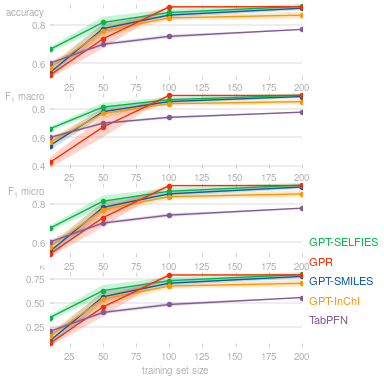

In [11]:
# plot the binary case, i.e. num_classes = 2
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))
    for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
        ax[i].plot(
            grouped_res.loc[2, "smiles", :].index,
            grouped_res.loc[2, "smiles", :][metric]["mean"],
            marker="o",
            label="GPT-SMILES",
        )
        ax[i].fill_between(
            grouped_res.loc[2, "smiles", :].index,
            grouped_res.loc[2, "smiles", :][metric]["mean"]
            - grouped_res.loc[2, "smiles", :][metric]["sem"],
            grouped_res.loc[2, "smiles", :][metric]["mean"]
            + grouped_res.loc[2, "smiles", :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_res.loc[2, "selfies", :].index,
            grouped_res.loc[2, "selfies", :][metric]["mean"],
            marker="o",
            label="GPT-SELFIES",
        )
        ax[i].fill_between(
            grouped_res.loc[2, "selfies", :].index,
            grouped_res.loc[2, "selfies", :][metric]["mean"]
            - grouped_res.loc[2, "selfies", :][metric]["sem"],
            grouped_res.loc[2, "selfies", :][metric]["mean"]
            + grouped_res.loc[2, "selfies", :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_res.loc[2, "inchi", :].index,
            grouped_res.loc[2, "inchi", :][metric]["mean"],
            marker="o",
            label="GPT-InChI",
        )
        ax[i].fill_between(
            grouped_res.loc[2, "inchi", :].index,
            grouped_res.loc[2, "inchi", :][metric]["mean"]
            - grouped_res.loc[2, "inchi", :][metric]["sem"],
            grouped_res.loc[2, "inchi", :][metric]["mean"]
            + grouped_res.loc[2, "inchi", :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_xgboost_res.loc[2, :].index,
            grouped_xgboost_res.loc[2, :][metric]["mean"],
            marker="o",
            label="GPR",
        )
        ax[i].fill_between(
            grouped_xgboost_res.loc[2, :].index,
            grouped_xgboost_res.loc[2, :][metric]["mean"]
            - grouped_xgboost_res.loc[2, :][metric]["sem"],
            grouped_xgboost_res.loc[2, :][metric]["mean"]
            + grouped_xgboost_res.loc[2, :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_tabpfn_res.loc[2, :].index,
            grouped_tabpfn_res.loc[2, :][metric]["mean"],
            marker="o",
            label="TabPFN",
        )
        ax[i].fill_between(
            grouped_tabpfn_res.loc[2, :].index,
            grouped_tabpfn_res.loc[2, :][metric]["mean"]
            - grouped_tabpfn_res.loc[2, :][metric]["sem"],
            grouped_tabpfn_res.loc[2, :][metric]["mean"]
            + grouped_tabpfn_res.loc[2, :][metric]["sem"],
            alpha=0.2,
        )

    matplotx.line_labels(ax[-1], fontsize=8)

    matplotx.ylabel_top("accuracy", ax=ax[0])
    matplotx.ylabel_top(r"F$_{1}$ macro", ax=ax[1])
    matplotx.ylabel_top(r"F$_{1}$ micro", ax=ax[2])
    matplotx.ylabel_top(r"$\kappa$", ax=ax[3])

    ax[-1].set_xlabel("training set size", labelpad=4)

    fig.savefig("freesolv-classification_results_binary.pdf", bbox_inches="tight")

In [12]:
find_learning_curve_intersection(
    grouped_res.loc[2, "selfies", :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_xgboost_res.loc[2, :].index,
        grouped_xgboost_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

3.066194938031193

In [13]:
find_learning_curve_intersection(
    grouped_res.loc[2, "selfies", :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_tabpfn_res.loc[2, :].index,
        grouped_tabpfn_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

1.347168303772582

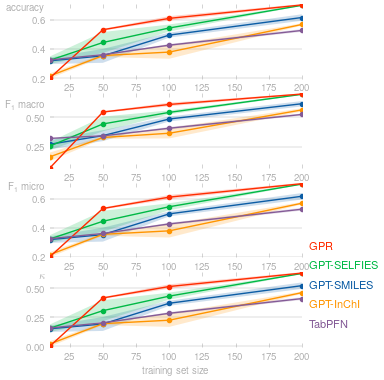

In [14]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

    # plot the binary case, i.e. num_classes = 2

    for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
        ax[i].plot(
            grouped_res.loc[5, "smiles", :].index,
            grouped_res.loc[5, "smiles", :][metric]["mean"],
            marker="o",
            label="GPT-SMILES",
        )
        ax[i].fill_between(
            grouped_res.loc[5, "smiles", :].index,
            grouped_res.loc[5, "smiles", :][metric]["mean"]
            - grouped_res.loc[5, "smiles", :][metric]["sem"],
            grouped_res.loc[5, "smiles", :][metric]["mean"]
            + grouped_res.loc[5, "smiles", :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_res.loc[5, "selfies", :].index,
            grouped_res.loc[5, "selfies", :][metric]["mean"],
            marker="o",
            label="GPT-SELFIES",
        )
        ax[i].fill_between(
            grouped_res.loc[5, "selfies", :].index,
            grouped_res.loc[5, "selfies", :][metric]["mean"]
            - grouped_res.loc[5, "selfies", :][metric]["sem"],
            grouped_res.loc[5, "selfies", :][metric]["mean"]
            + grouped_res.loc[5, "selfies", :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_res.loc[5, "inchi", :].index,
            grouped_res.loc[5, "inchi", :][metric]["mean"],
            marker="o",
            label="GPT-InChI",
        )
        ax[i].fill_between(
            grouped_res.loc[5, "inchi", :].index,
            grouped_res.loc[5, "inchi", :][metric]["mean"]
            - grouped_res.loc[5, "inchi", :][metric]["sem"],
            grouped_res.loc[5, "inchi", :][metric]["mean"]
            + grouped_res.loc[5, "inchi", :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_xgboost_res.loc[5, :].index,
            grouped_xgboost_res.loc[5, :][metric]["mean"],
            marker="o",
            label="GPR",
        )
        ax[i].fill_between(
            grouped_xgboost_res.loc[5, :].index,
            grouped_xgboost_res.loc[5, :][metric]["mean"]
            - grouped_xgboost_res.loc[5, :][metric]["sem"],
            grouped_xgboost_res.loc[5, :][metric]["mean"]
            + grouped_xgboost_res.loc[5, :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_tabpfn_res.loc[5, :].index,
            grouped_tabpfn_res.loc[5, :][metric]["mean"],
            marker="o",
            label="TabPFN",
        )
        ax[i].fill_between(
            grouped_tabpfn_res.loc[5, :].index,
            grouped_tabpfn_res.loc[5, :][metric]["mean"]
            - grouped_tabpfn_res.loc[5, :][metric]["sem"],
            grouped_tabpfn_res.loc[5, :][metric]["mean"]
            + grouped_tabpfn_res.loc[5, :][metric]["sem"],
            alpha=0.2,
        )

    matplotx.line_labels(ax[-1], fontsize=8)

    matplotx.ylabel_top("accuracy", ax=ax[0])
    matplotx.ylabel_top(r"F$_{1}$ macro", ax=ax[1])
    matplotx.ylabel_top(r"F$_{1}$ micro", ax=ax[2])
    matplotx.ylabel_top(r"$\kappa$", ax=ax[3])

    ax[-1].set_xlabel("training set size", labelpad=4)
    fig.savefig("freesolv-classification_results_5_class.pdf", bbox_inches="tight")